Notebook for running scripts in the simclr-pytorch repo on Google Colab

In [ ]:
# Mount google drive
from google.colab import drive
ROOT = "/content/drive"
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# cd to /Repo
%cd drive/MyDrive/Repos/simclr-pytorch-cvf/
%pwd

/content/drive/MyDrive/Repos/simclr-pytorch-cvf


'/content/drive/MyDrive/Repos/simclr-pytorch-cvf'

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...


In [ ]:
!conda --version

conda 22.9.0


In [ ]:
%cd drive/MyDrive/Repos/simclr-pytorch-cvf/
!conda env create -f environment.yml

/content/drive/MyDrive/Repos/simclr-pytorch-cvf
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



_libgcc_mutex-0.1    | 3 KB      | : 100% 1.0/1 [00:00<00:00,  4.62it/s]
blas-1.0             | 6 KB      | : 100% 1.0/1 [00:00<00:00,  5.60it/s]
ninja-1.10.2         | 1.4 MB    | : 100% 1.0/1 [00:00<00:00,  4.41it/s]
libuv-1.40.0         | 736 KB    | : 100% 1.0/1 [00:00<00:00,  6.85it/s]
pip-20.3.1           | 1.8 MB    | : 100% 1.0/1 [00:00<00:00,  1.27it/s]
six-1.15.0           | 27 KB     | : 100% 1.0/1 [00:00<00:00,  4.04it/s]               
pickleshare-0.7.5    | 13 KB     | : 100% 1.0/1 [00:00<00:00, 19.05it/s]
parso-0.7.0          | 72 KB     | : 100% 1.0/1 [00:00<00:00, 11.00it/s]
wcwidth-0.2.5  

In [ ]:
!conda env list

# conda environments:
#
base                     /usr/local
simclr_pytorch           /usr/local/envs/simclr_pytorch



In [ ]:
# run this in CLI 
#%cd drive/MyDrive/Repos/simclr-pytorch-cvf/
!source activate /usr/local/envs/simclr_pytorch

[Errno 2] No such file or directory: 'drive/MyDrive/Repos/simclr-pytorch-cvf/'
/content/drive/MyDrive/Repos/simclr-pytorch-cvf


In [ ]:
# run this in CLI for pre-training
# !python train.py --config configs/cifar_train_epochs60_bs256.yaml

# run this in CLI for linear classifier training
# python train.py --config configs/cifar_eval.yaml --encoder_ckpt logs/exman-train.py/runs/000004/checkpoint-12000.pth.tar

#git pull

Traceback (most recent call last):
  File "train.py", line 5, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'


In [ ]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from utils import datautils
import numpy as np
import PIL
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
#testset = datasets.CIFAR10(root train=False, download=True)
REPO_PATH = os.path.join(ROOT, "MyDrive/Repos/simclr-pytorch-cvf")

In [ ]:
testset = datasets.CIFAR10(root=REPO_PATH, train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Repos/simclr-pytorch-cvf/cifar-10-python.tar.gz to /content/drive/MyDrive/Repos/simclr-pytorch-cvf


In [ ]:
len(testset)

10000

In [ ]:
testset.data.shape

(10000, 32, 32, 3)

In [ ]:
samp = testset.data[1]

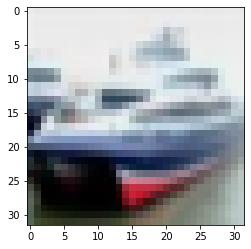

In [ ]:
plt.imshow(samp)

In [ ]:
def get_color_distortion(s=1.0):
    # s is the strength of color distortion.
    # given from https://arxiv.org/pdf/2002.05709.pdf
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([
        rnd_color_jitter,
        rnd_gray])
    return color_distort

class Clip(object):
    def __call__(self, x):
        return torch.clamp(x, 0, 1)

In [ ]:
# train_transform = transforms.Compose([
#                       transforms.RandomResizedCrop(
#                         32,
#                         scale=(self.hparams.scale_lower, 1.0),
#                         interpolation=PIL.Image.BICUBIC,
#                 ),
#                 transforms.RandomHorizontalFlip(),
#                 get_color_distortion(s=self.hparams.color_dist_s), #datautils.
#                 transforms.ToTensor(),
#                 Clip(), #datautils.
#             ])
# test_transform = train_transform
train_transform = transforms.Compose([
                      transforms.RandomResizedCrop(
                        32,
                        scale=(.08, 1.0),
                        interpolation=PIL.Image.BICUBIC,
                ),
                transforms.RandomHorizontalFlip(),
                get_color_distortion(s=1.), #datautils.
                transforms.ToTensor(),
                Clip(), #datautils.
            ])
test_transform = train_transform

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:899: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
test_transform

Compose(
    RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic), antialias=None)
    RandomHorizontalFlip(p=0.5)
    Compose(
    RandomApply(
    p=0.8
    ColorJitter(brightness=[0.19999999999999996, 1.8], contrast=[0.19999999999999996, 1.8], saturation=[0.19999999999999996, 1.8], hue=[-0.2, 0.2])
)
    RandomGrayscale(p=0.2)
)
    ToTensor()
)

In [ ]:
testset_aug = datasets.CIFAR10(root=REPO_PATH, train=False, download=True, transform=test_transform)

Files already downloaded and verified


In [ ]:
# testset.transform

In [ ]:
# testset.transforms

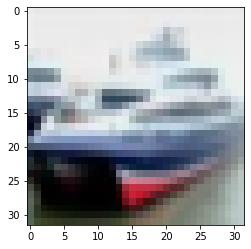

In [ ]:
samp = testset_aug.data[1]
plt.imshow(samp)

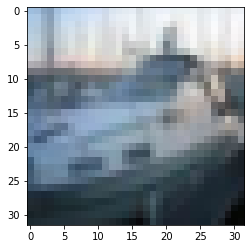

In [ ]:
samp_aug = testset_aug.data[2]
plt.imshow(samp_aug)

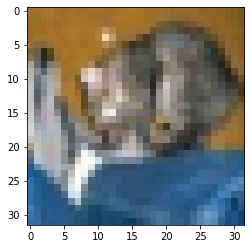

In [ ]:
samp_aug = testset_aug.data[0]
plt.imshow(samp_aug)

In [ ]:
btch_sz = 4
testloader_aug = torch.utils.data.DataLoader(testset_aug, batch_size=btch_sz,
                                         shuffle=False, num_workers=2)

In [ ]:
dataiter = iter(testloader_aug)
images, labels = next(dataiter)

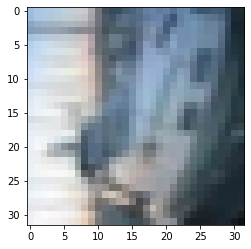

In [ ]:
plt.imshow(np.transpose(images[2]))

In [ ]:
testset.data.shape

(10000, 32, 32, 3)

In [ ]:
testset_aug.transforms

StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic), antialias=None)
               RandomHorizontalFlip(p=0.5)
               Compose(
               RandomApply(
               p=0.8
               ColorJitter(brightness=[0.19999999999999996, 1.8], contrast=[0.19999999999999996, 1.8], saturation=[0.19999999999999996, 1.8], hue=[-0.2, 0.2])
           )
               RandomGrayscale(p=0.2)
           )
               ToTensor()
           )

In [ ]:
# testset_aug.transforms(torch.tensor(samp_aug))

TypeError: ignored

In [ ]:
labels

tensor([3, 8, 8, 0])

In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	augment_experiment.ipynb
	cifar-10-batches-py/
	cifar-10-python.tar.gz
	models/data/

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git add augment_experiment.ipynb

In [ ]:
!git commit -m "new notebook for augmentation exploration"


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@d4e6e39b2c68.(none)')


In [ ]:
!git config --global user.name "Cole Frank"